<a href="https://colab.research.google.com/github/Deok97/Multi-object-Classification/blob/main/Object_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google Drive와 연결시 사용

In [ ]:
# %cd /content/gdrive/MyDrive/Colab\ Notebooks



---



In [1]:
%matplotlib inline

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MSE, CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_crossentropy

from keras.datasets import mnist
import matplotlib.pyplot as plt
from google.colab import drive
import imageio
import glob
import cv2 as cv
import imutils

from random import Random

In [48]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# handgun dataset preparation from [DaSCI's Github](https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Pistol%20classification)  
### git clone certain directory: https://webnautes.tistory.com/1387 

In [3]:
%mkdir dataset
%cd dataset
!git init
!git config core.sparsecheckout true
!git remote add -f origin https://github.com/ari-dasci/OD-WeaponDetection.git

# git clone Pistol dataset
!echo 'Pistol classification/AAAPistol' > .git/info/sparse-checkout
!git pull origin master

/content/dataset
Initialized empty Git repository in /content/dataset/.git/
Updating origin
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10242/10242), done.
remote: Total 50755 (delta 12), reused 11652 (delta 1), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 34.90 MiB/s, done.
Resolving deltas: 100% (10979/10979), done.
From https://github.com/ari-dasci/OD-WeaponDetection
 * [new branch]        main       -> origin/main
 * [new branch]        master     -> origin/master
From https://github.com/ari-dasci/OD-WeaponDetection
 * branch              master     -> FETCH_HEAD
From https://github.com/ari-dasci/OD-WeaponDetection
 * branch              master     -> FETCH_HEAD
Already up to date.


### git 초기화 & 다시 git clone

In [11]:
# initialize branch
%rm -r .git
!git init
!git config core.sparsecheckout true
!git remote add -f origin https://github.com/ari-dasci/OD-WeaponDetection.git

# git clone Knife dataset
!echo 'Knife classification/AAAKnife' > .git/info/sparse-checkout
!git pull origin master

Initialized empty Git repository in /content/dataset/.git/
Updating origin
remote: Enumerating objects: 50755, done.
remote: Counting objects: 100% (11673/11673), done.
remote: Compressing objects: 100% (10242/10242), done.
remote: Total 50755 (delta 12), reused 11652 (delta 1), pack-reused 39082
Receiving objects: 100% (50755/50755), 2.26 GiB | 35.51 MiB/s, done.
Resolving deltas: 100% (10979/10979), done.
From https://github.com/ari-dasci/OD-WeaponDetection
 * [new branch]        main       -> origin/main
 * [new branch]        master     -> origin/master
From https://github.com/ari-dasci/OD-WeaponDetection
 * branch              master     -> FETCH_HEAD


# Preprocessing

### Define helper preprocessing function

In [13]:
"""
Description
    shape: image shape to deserve
    dirPath: directory path to image directory
    cls_arr:
      shape: (1, N)
      N: N개의 클래스

    return: (image dataset, class of image dataset)
"""
def prepData(shape: tuple, dirPath: str, cls_arr: np.ndarray):
  dataset = np.zeros(shape)
  for im_path in glob.glob(dirPath):
    im = cv.imread(im_path, cv.IMREAD_COLOR)
    if im.ndim == 3:
      if im.shape[2] == 3:
        im = cv.resize(im, dsize=(231, 231))
        im = im.reshape(1, 231, 231, 3)
        dataset = np.append(dataset, im, axis=0)
  dataset = dataset[1:]
  dataset = dataset.astype('uint8')

  # Image 별로 클래스 나누기
  # dataset_class = [[1., 0.]]
  dataset_class = cls_arr
  dataset_class = np.repeat(dataset_class, repeats=dataset.shape[0], axis=0)
  dataset_class = dataset_class.reshape(-1, 1, 1, 2)

  return dataset, dataset_class



In [14]:
shape = (1, 231, 231, 3)
dirPath = '/content/dataset/Pistol classification/AAAPistol/*.jpg'
cls_arr = [[1., 0.]]
pistol_data, pistol_cls = prepData(shape, dirPath, cls_arr)

In [15]:
shape = (1, 231, 231, 3)
dirPath = '/content/dataset/Knife classification/AAAKnife/*.jpg'
cls_arr = [[0., 1.]]
knife_data, knife_cls = prepData(shape, dirPath, cls_arr)

### Plotting sample images  

((784, 231, 231, 3), (784, 1, 1, 2))

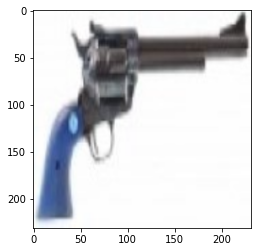

In [77]:
plt.imshow(pistol_data[0])
pistol_data.shape, pistol_cls.shape

((635, 231, 231, 3), (635, 1, 1, 2))

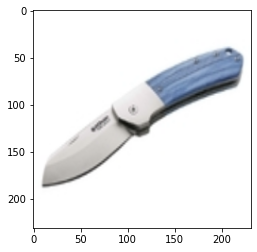

In [17]:
plt.imshow(knife_data[0])
knife_data.shape, knife_cls.shape

### Merge data

### Split & Merge & [Random Shuffle(with seed)](https://stackoverflow.com/questions/19306976/python-shuffling-with-a-parameter-to-get-the-same-result) data  

In [90]:
# 데이터셋을 merge하고 취중되게 split 하게되면, 특정 클래스에 과적합된다
# 7:3 split
ratio_pistol = int(0.7 * len(pistol_data))
ratio_knife = int(0.7 * len(knife_data))

pistol_train_X, pistol_test_X = (pistol_data[:ratio_pistol], pistol_data[ratio_pistol:])
pistol_train_y, pistol_test_y = (pistol_cls[:ratio_pistol], pistol_cls[ratio_pistol:])

knife_train_X, knife_test_X = (knife_data[:ratio_knife], knife_data[ratio_knife:])
knife_train_y, knife_test_y = (knife_cls[:ratio_knife], knife_cls[ratio_knife:])

train_X = np.concatenate([pistol_train_X, knife_train_X], axis=0)
train_y = np.concatenate([pistol_train_y, knife_train_y], axis=0)
test_X = np.concatenate([pistol_test_X, knife_test_X], axis=0)
test_y = np.concatenate([pistol_test_y, knife_test_y], axis=0)

Random(4).shuffle(train_X)
Random(4).shuffle(train_y)

Random(5).shuffle(test_X)
Random(5).shuffle(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((992, 231, 231, 3), (992, 1, 1, 2), (427, 231, 231, 3), (427, 1, 1, 2))

# Overfeat Model Design from Fast Classification
출처: https://arxiv.org/abs/1312.6229  
The main difference with the localization task, is the necessity to predict a background class when no object is present


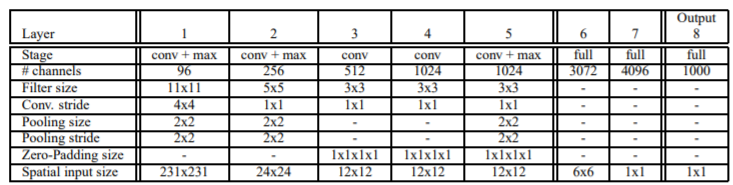

In [87]:
K.clear_session()

# Overfeat 논문에서는 FC Layer을 Convolutional Layer로 변환
# Fully Convolutional Network을 구축
# Our model uses the same fixed input size approach proposed by Krizhevsky et al(AlexNet)
# -> (231, 231)

# input layer
input_ = Input(shape=(231, 231, 3))

# Backbone - 1st layer
# The weights in the network are initialized randomly with (µ, σ) = (0, 1 × 10−2) -> kernel_initializer=RandomNormal(0, 0.01)
# ℓ2 weight decay of 0.00001 -> kernel_regularizer=l2(0.00001)
conv_0 = Conv2D(filters=96/8, kernel_size=(11, 11), padding='valid', strides=4, activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(input_)
max_0 = MaxPooling2D(pool_size=2, strides=2)(conv_0)

# Backbone - 2nd layer
conv_1 = Conv2D(filters=256/8, kernel_size = 5, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_0)
max_1 = MaxPooling2D(pool_size=2, strides=2)(conv_1)

# Backbone - 3rd layer
conv_2 = Conv2D(filters = 512/8, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_1)

# Backbone - 4th layer
conv_3 = Conv2D(filters = 1024/8, kernel_size=3, strides = 1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_2)

# Backbone - 5th layer
conv_4 = Conv2D(filters=1024/8, kernel_size = 3, strides=1, padding='same', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_3)
max_2 = MaxPooling2D(pool_size=2, strides=2)(conv_4)


In [88]:
# Classification - header 1
conv_5 = Conv2D(filters=4096/8, kernel_size = 6, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(max_2)

# Classification - header 2
conv_6 = Conv2D(filters=1024/8, kernel_size = 1, strides=1, padding='valid', activation='relu',
                kernel_initializer=RandomNormal(0, 0.01), kernel_regularizer=l2(0.00001))(conv_5)

# Classification - header 3; output layer
output_ = Conv2D(filters=2, kernel_size = 1, strides=1, padding='valid', activation='softmax')(conv_6)

# Loss & Metrics Definition

### 1. MSE + Categorical_crossentropy

In [64]:
def overfeat_cee(true, pred):
  cee = CategoricalCrossentropy()
  cee_ = cee(true, pred)
  return cee_

### 2. mAP
* AP: Average precision computes the average precision value for recall value over 0 to 1  
* mAP: sum of AP / number of classes  
* 참고: https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173 

## 모델 컴파일

In [89]:
model = Model(input_, output_)

# Adam implicitly performs coordinate-wise gradient clipping
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'categorical_crossentropy'])

print(model.summary())

"""
반영 안된 사항
  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler
  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels
  - We present these(pixels) to the network n mini-batches of size 128
  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier
    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.
"""

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 231, 231, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 12)        4368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9632      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496 

'\n반영 안된 사항\n  - The learning rate is successively decreased by a factor of 0.5 after (30, 50, 60, 70, 80) epochs -> learning rate scheduler\n  - We extract 5 random crops (and their horizontal flips) of size 221x221 pixels\n  - We present these(pixels) to the network n mini-batches of size 128\n  - DropOut with a rate of 0.5 is employed on the fully connected layers (6th and 7th) in the classifier\n    -> DropOut은 Fully Connected Layers을 Convolutional Layers로 변경하면서 적용 효과가 달라지게 됨.\n'

## 모델 학습

In [91]:
model.fit(train_X, train_y, batch_size=128, epochs=50)

Epoch 1/50
8/8 [==============================] - 2s 75ms/step - loss: 0.6250 - accuracy: 0.8014 - categorical_crossentropy: 0.6224
Epoch 2/50
8/8 [==============================] - 1s 62ms/step - loss: 0.3864 - accuracy: 0.8942 - categorical_crossentropy: 0.3839
Epoch 3/50
8/8 [==============================] - 1s 64ms/step - loss: 0.3476 - accuracy: 0.8942 - categorical_crossentropy: 0.3453
Epoch 4/50
8/8 [==============================] - 1s 64ms/step - loss: 0.3491 - accuracy: 0.8942 - categorical_crossentropy: 0.3471
Epoch 5/50
8/8 [==============================] - 1s 64ms/step - loss: 0.3351 - accuracy: 0.8942 - categorical_crossentropy: 0.3333
Epoch 6/50
8/8 [==============================] - 1s 66ms/step - loss: 0.3245 - accuracy: 0.8942 - categorical_crossentropy: 0.3228
Epoch 7/50
8/8 [==============================] - 1s 64ms/step - loss: 0.2905 - accuracy: 0.8942 - categorical_crossentropy: 0.2889
Epoch 8/50
8/8 [==============================] - 1s 64ms/step - loss: 0.210

## Visualization

In [98]:
# 지수(Scientific) format -> float format
np.set_printoptions(precision=4, suppress=True)

In [92]:
# 여러개의 이미지에 대한 통합 결과를 보여주는 배열
# indexArray: 여러개의 index값을 갖는 배열
def showResults(indexArray):
  for index in indexArray:
    img_ = test_X[index]
    img = img_.reshape(1, 231, 231, 3)
    pred = model.predict(img)

    plt.imshow(img_)
    plt.title('true: {} | pred: {}'.format(test_y[index], pred))
    plt.show()

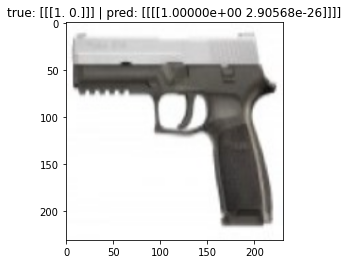

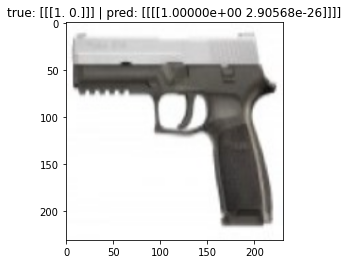

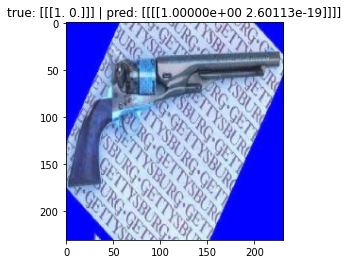

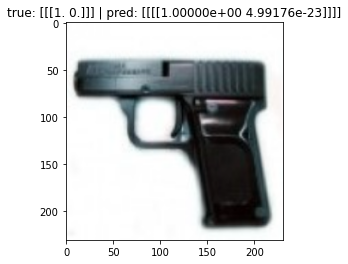

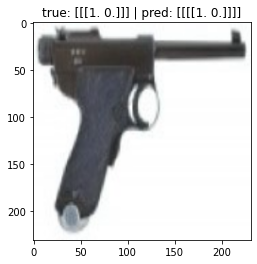

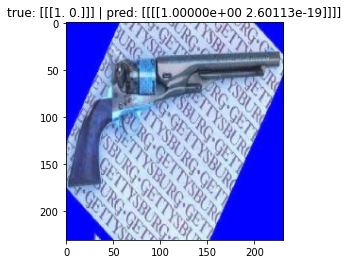

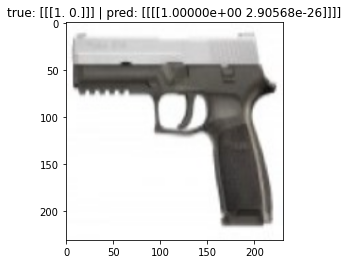

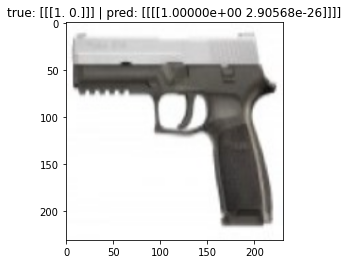

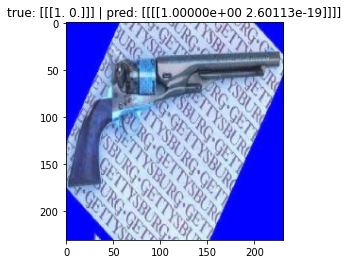

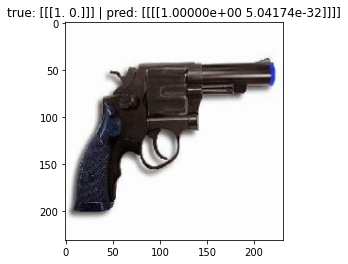

In [93]:
indexArray = range(0, 10)
showResults(indexArray)

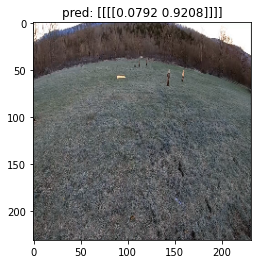

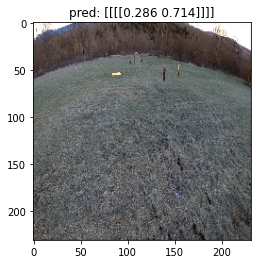

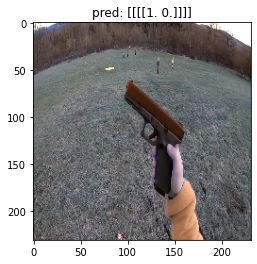

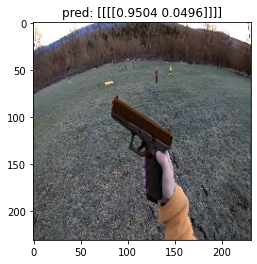

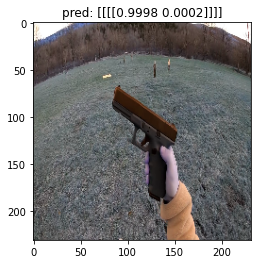

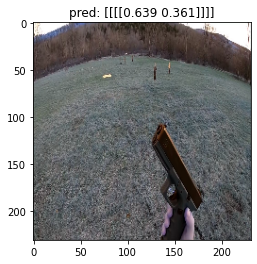

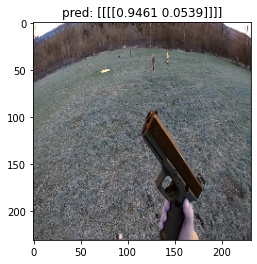

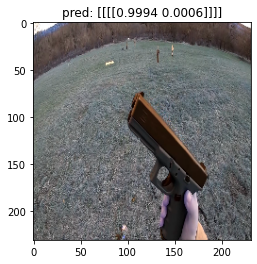

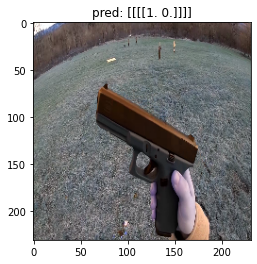

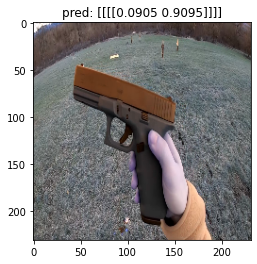

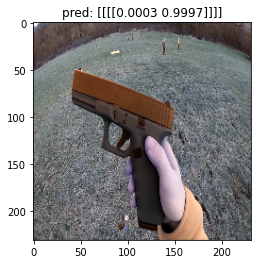

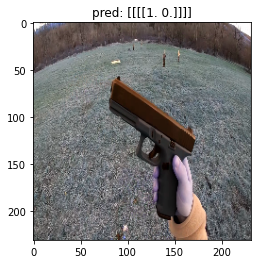

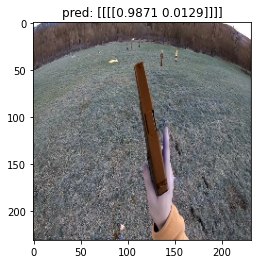

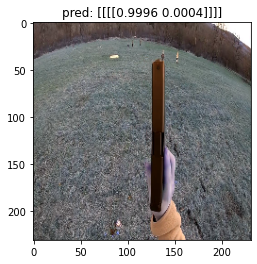

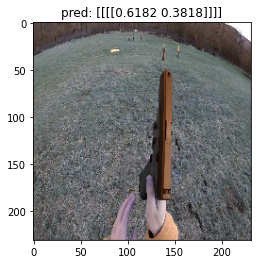

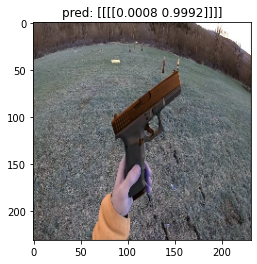

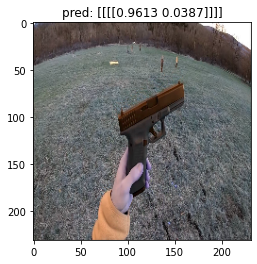

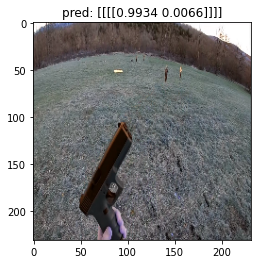

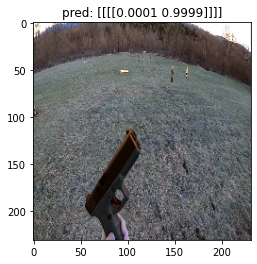

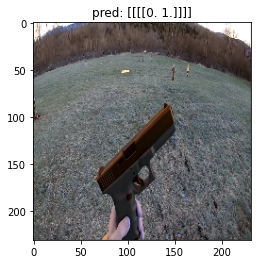

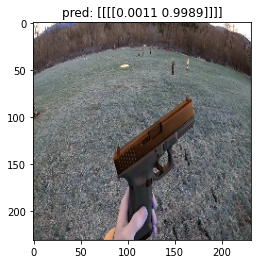

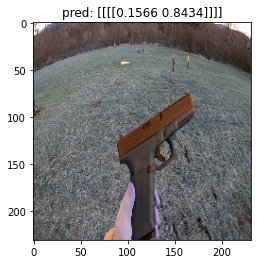

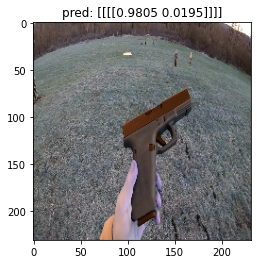

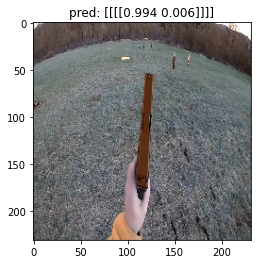

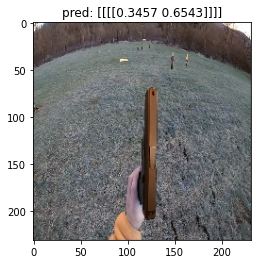

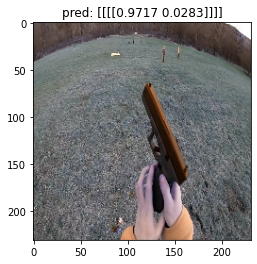

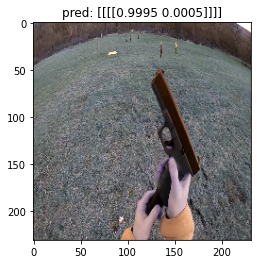

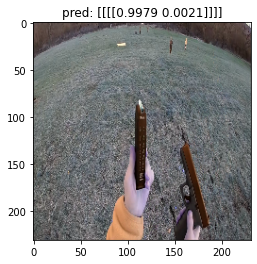

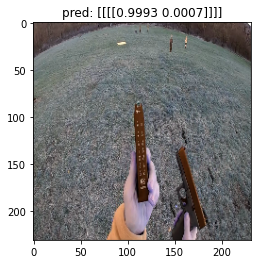

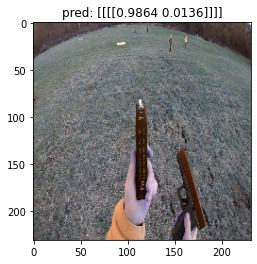

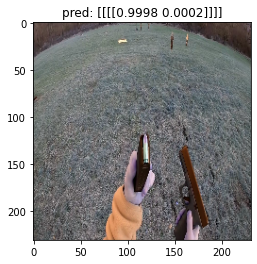

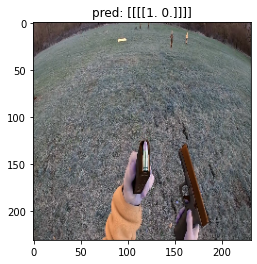

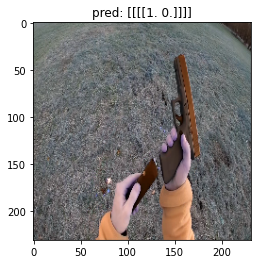

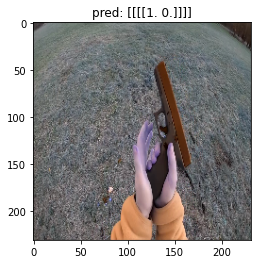

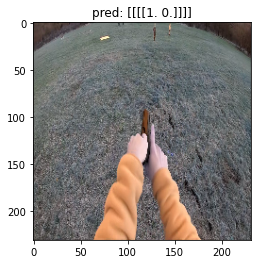

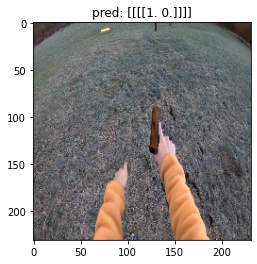

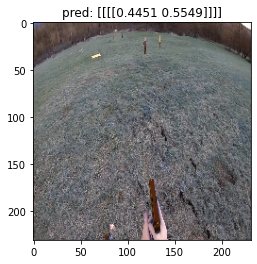

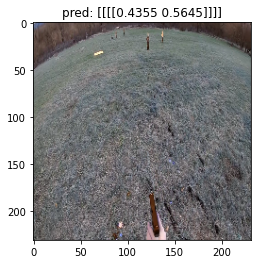

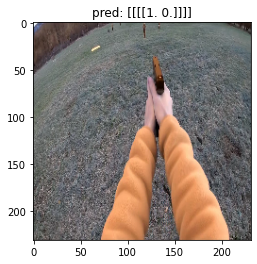

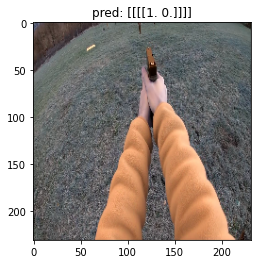

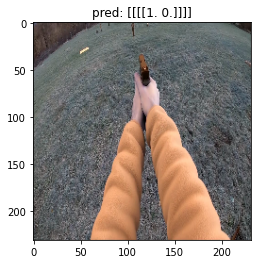

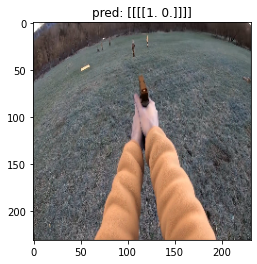

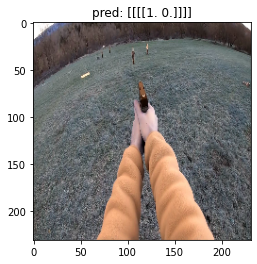

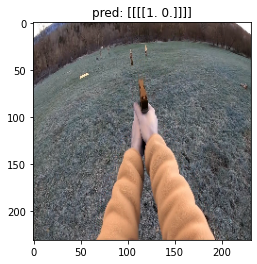

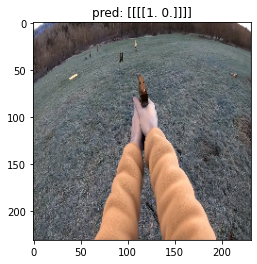

KeyboardInterrupt: ignored

In [99]:

cap = cv.VideoCapture('/content/gdrive/MyDrive/sample/pistol_sample.mp4')

i=0
if not cap.isOpened():
  print('cannot open video')
  exit()

while True:
  ret, frame = cap.read()
  if ret is None:
    print('cannot read frame or Ending stream')
    break
  if i%24 ==0:
    frame_ = cv.resize(frame, (231, 231))
    frame = frame_.reshape(1, 231, 231, 3)
    pred = model.predict(frame)

    plt.imshow(frame_)
    plt.title('pred: {}'.format(pred))
    plt.show()
  i +=1
  
